In [1]:
import pandas as pd
import numpy as np
import pypfopt
from pypfopt import risk_models, expected_returns
import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters
from pandas_datareader import data
#pypfopt.__version__
sns.set_theme(style="white")

In [2]:
from get_equities_data import DataIngester

In [3]:
dataIngester = DataIngester()

In [17]:
companies = [
"MSFT", 
"AMZN", 
"META", 
"BABA", 
"GE", 
"GOOG", 
"AMD", 
"WMT", 
"BAC", 
"GM", 
"T", 
"UAA", 
"MA", 
"PFE", 
"JPM", 
"SBUX"]

In [18]:
df = dataIngester.yahoo_set_market_request(
    tickers = companies,
    vendor_tickers= companies)

2023-11-02 20:22:20,919 - findatapy.market.datavendorweb - INFO - Request Yahoo data
[*********************100%%**********************]  16 of 16 completed
2023-11-02 20:22:21,887 - findatapy.market.datavendorweb - INFO - Completed request from Yahoo.
2023-11-02 20:22:23,952 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_1029__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M... to Redis: Error 10061 connecting to 127.0.0.1:6379. No connection could be made because the target machine actively refused it.


In [19]:
past_df, future_df = df.iloc[:-250], df.iloc[-250:]
future_cov = risk_models.sample_cov(future_df)

sample_cov = risk_models.sample_cov(past_df)
corr = sample_cov

In [20]:
df.head(5)

,MSFT.close,AMZN.close,META.close,BABA.close,GE.close,GOOG.close,AMD.close,WMT.close,BAC.close,GM.close,T.close,UAA.close,MA.close,PFE.close,JPM.close,SBUX.close
Date,,,,,,,,,,,,,,,,
2013-11-05,36.639999,17.944500,50.110001,NaN,158.650085,25.442635,3.33,77.419998,13.93,37.090000,26.835346,20.047501,73.638000,29.639469,51.950001,40.994999
2013-11-06,38.180000,17.809000,49.119999,NaN,161.532455,25.473270,3.32,78.160004,13.96,36.590000,27.054380,19.815001,73.387001,29.383303,52.099998,40.564999
2013-11-07,37.500000,17.177999,47.560001,NaN,159.730972,25.104652,3.28,77.510002,13.80,35.919998,26.518127,19.087500,72.132004,29.326376,51.650002,39.535000
2013-11-08,37.779999,17.515499,47.529999,NaN,162.433197,25.305897,3.27,77.959999,14.32,36.660000,26.563444,19.735001,73.446999,29.715370,53.959999,40.599998
2013-11-11,37.590000,17.719000,46.200001,NaN,162.192993,25.170404,3.34,79.010002,14.40,36.680000,26.457705,20.070000,74.115997,29.639469,54.099998,40.494999


<Axes: >

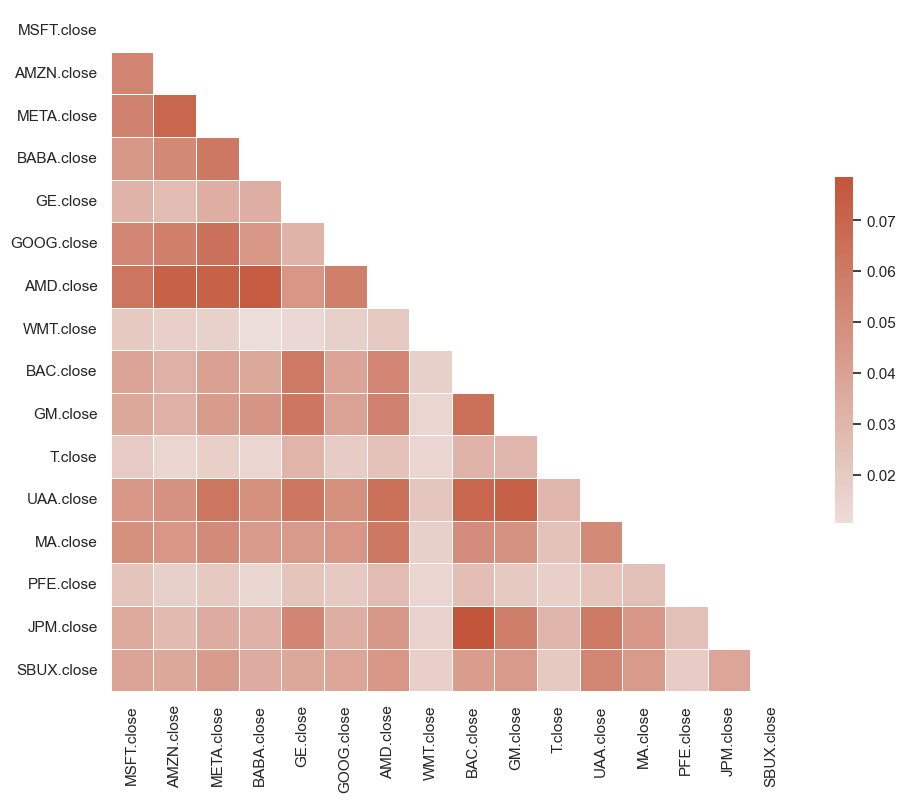

In [21]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

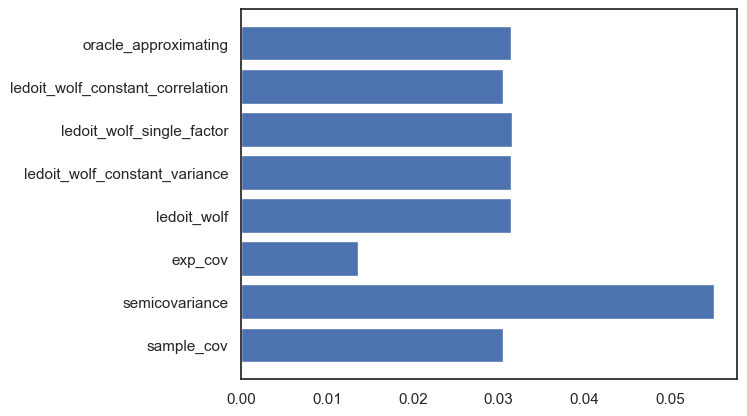

In [22]:
future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(df, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

<Axes: >

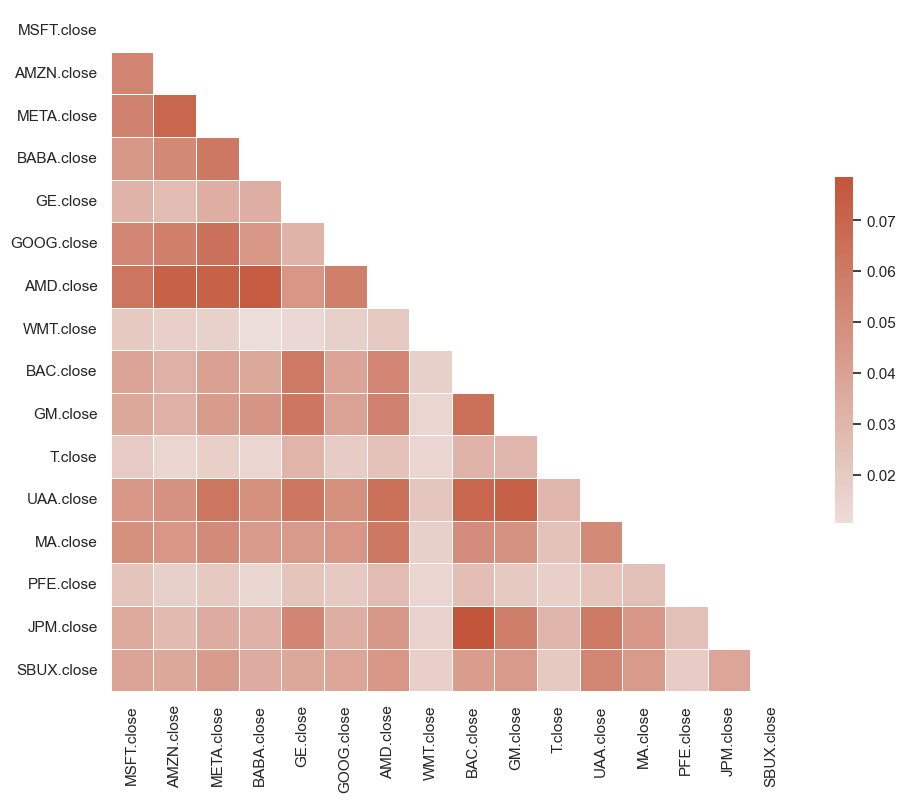

In [23]:
exp_cov = risk_models.exp_cov(past_df)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(exp_cov, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<Axes: >

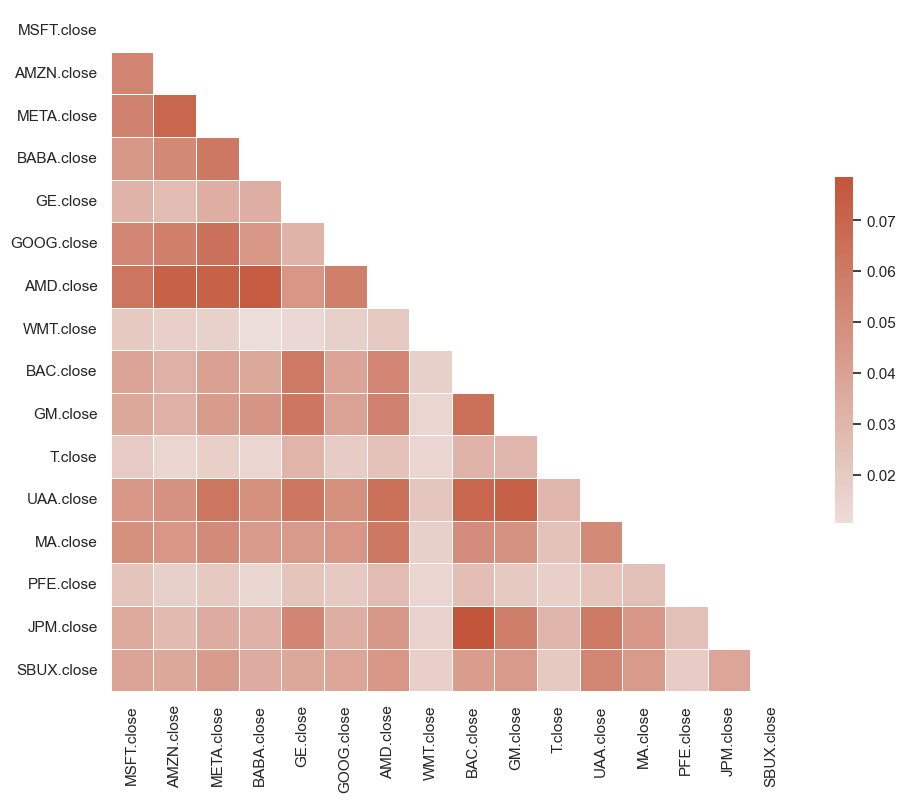

In [24]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(future_cov, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

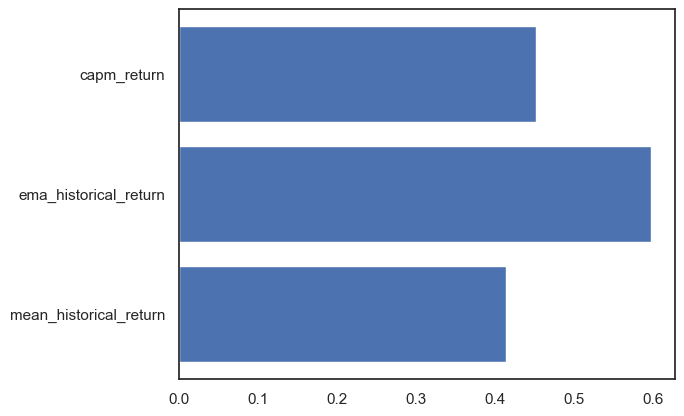

In [25]:

future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

In [26]:
print(mean_abs_errors)


[0.4133551681763513, 0.5969503808168425, 0.45112405500741143]


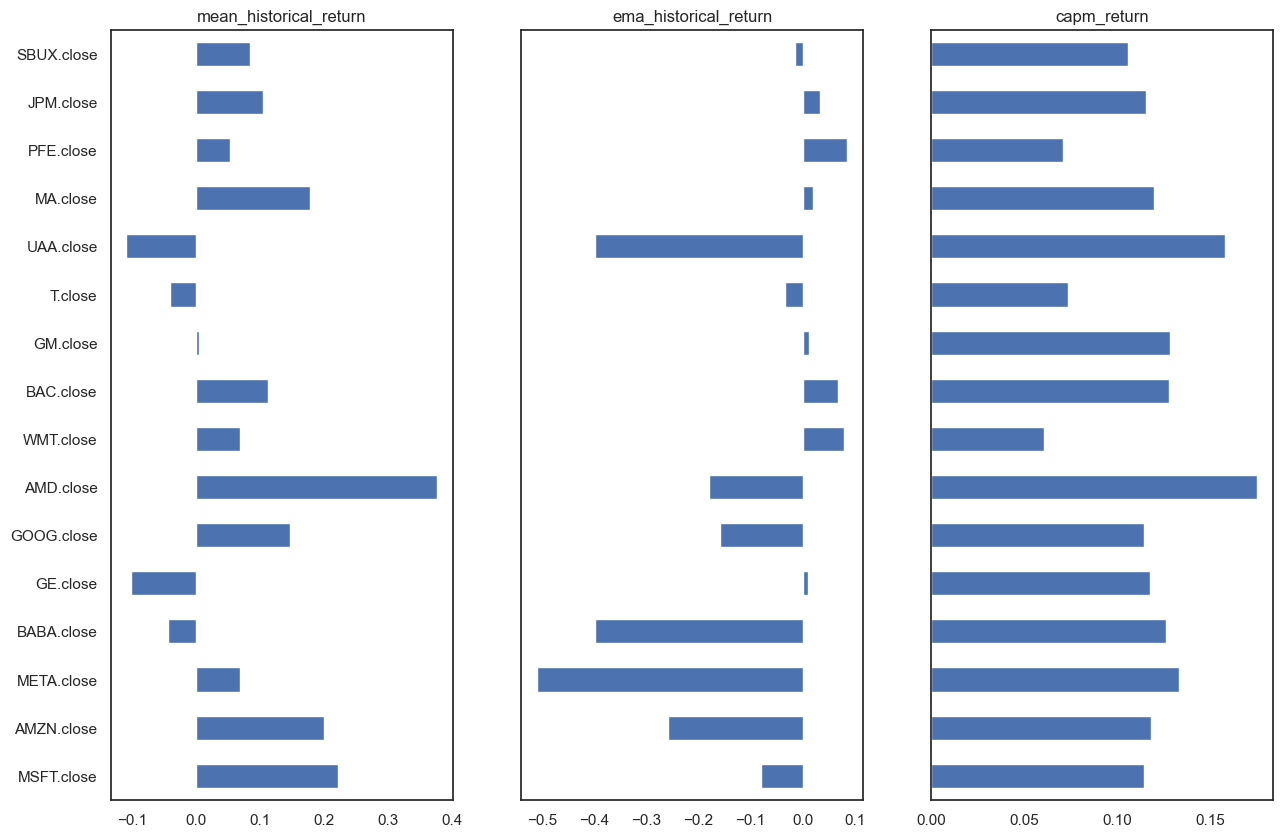

In [27]:
fig, axs = plt.subplots( 1, len(return_methods),sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(past_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])


In [28]:
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = qs.utils.download_returns('META')

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas() :)
stock.sharpe()

[*********************100%%**********************]  1 of 1 completed


0.6570029739292802

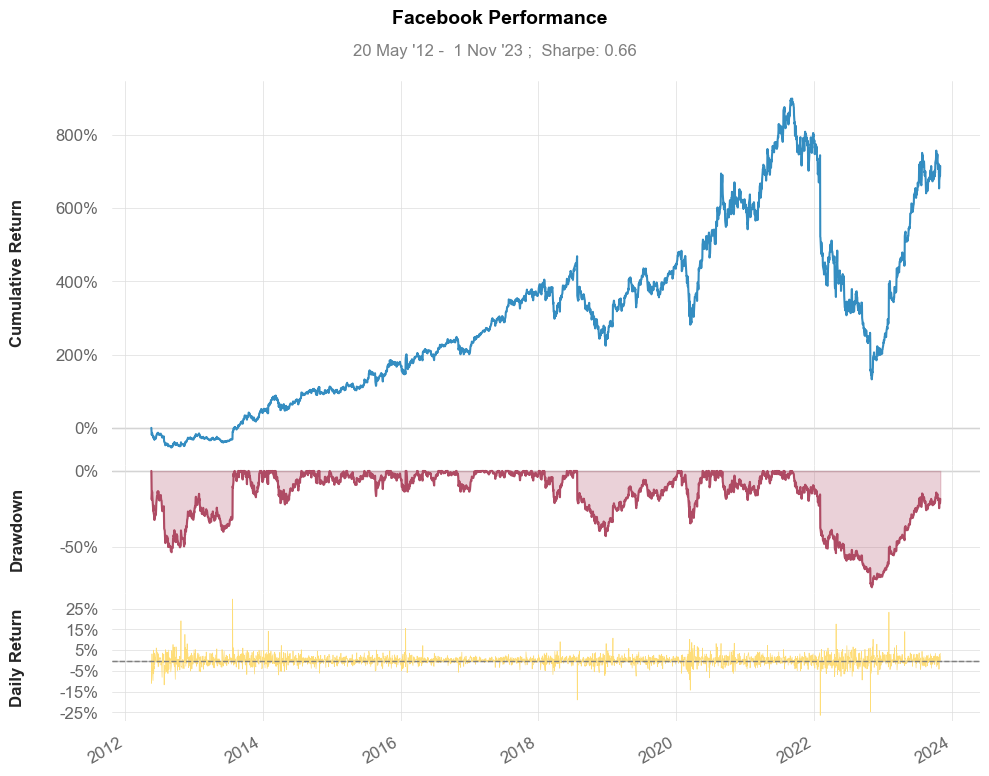

In [29]:
qs.plots.snapshot(stock, title='Facebook Performance', show=True)

# can also be called via:
# stock.plot_snapshot(title='Facebook Performance', show=True)

In [32]:
qs.reports.html(stock, "GOOG")

[*********************100%%**********************]  1 of 1 completed


c:\Users\Ivan\Desktop\Office_work_related\Project1\Blockchain_Portfolio_Management\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Ivan\Desktop\Office_work_related\Project1\Blockchain_Portfolio_Management\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Ivan\Desktop\Office_work_related\Project1\Blockchain_Portfolio_Management\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is 

In [1]:
import streamlit as st
import streamlit_authenticator as stauth

In [2]:
hashed_passwords = stauth.Hasher(['def456']).generate()

In [3]:
hashed_passwords

['$2b$12$g0kw8yxegBhJDIM6.dLppO2TkqIJ5zDYXXPW.S8kj782vEi6xLGXG']